In [1]:
# from pydap.client import open_url
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset

from net_cdf_functions import *
from degree_day_equations import single_sine_horizontal_cutoff
import numpy as np
from processing_functions import *
import pandas as pd
import dask
import dask.array as da
import warnings

# %matplotlib inline
# import dask
from dask.distributed import Client

# check if port is already in use

# client = Client(n_workers=3, threads_per_worker=1, memory_limit="2GB")
# client

data_path = "/media/thom/Q/data/"
# data_path = 'data/test/'

In [2]:
client = Client(n_workers=3, threads_per_worker=2, memory_limit="2GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 5.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38893,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 5.59 GiB
Comm: tcp://127.0.0.1:45979,Total threads: 2
Dashboard: http://127.0.0.1:45281/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:44701,


In [9]:
'''
# fetch and save data 2000-2020
for year in range(2019, 2020):
    fetch_and_save_data(year, 1, 10, data_path)
    '''

Saved data for 20190101 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190101.nc
Saved data for 20190102 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190102.nc
Saved data for 20190103 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190103.nc
Saved data for 20190104 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190104.nc
Saved data for 20190105 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190105.nc
Saved data for 20190106 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190106.nc
Saved data for 20190107 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190107.nc
Saved data for 20190108 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190108.nc
Saved data for 20190109 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190109.nc
Saved data for 20190110 to /media/thom/Q/data/PRISM/2019/PRISM_combo_20190110.nc


In [58]:
def subset_dataset_by_coords(dataset, lat, lon, window_size=None):
    if window_size is not None:
        # Define the window boundaries
        lat_min = lat - window_size
        lat_max = lat + window_size
        lon_min = lon - window_size
        lon_max = lon + window_size

        # Create boolean masks for the coordinate ranges
        mask_lat = (dataset.latitude >= lat_min) & (dataset.latitude <= lat_max)
        mask_lon = (dataset.longitude >= lon_min) & (dataset.longitude <= lon_max)

        # Apply the mask using .where() and drop the data points outside the window
        print("masking 3d")
        subset = dataset.where(mask_lat & mask_lon, drop=True)
        nan_mask = subset.isnull().any(dim="t")
        # combine tmin and tmax into one mask
        nan_mask = nan_mask.tmin | nan_mask.tmax

        #subset = subset.fillna(-9999)
        # Check if the subset contains only NaN values

        # Create a 2D mask for NaN values in the subset
        # .any(dim="t")
        return subset, nan_mask
    else:
        print("masking 1d")
        subset = dataset.sel(latitude=lat, longitude=lon, method="nearest")
        # Check if the subset contains only NaN values
        # print any nan values
        print(subset.isnull(keep_attrs=True))

        # Create a mask for NaN values in the subset
        nan_mask = subset.isnull().any(dim="t")
        nan_mask = nan_mask.tmin | nan_mask.tmax

        return subset, nan_mask

In [59]:
prism_year_stack = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    # combine="by_coords",
    drop_variables=["ppt", "tmean"],
)
# prism_year_stack = prism_year_stack.chunk({"latitude": 100, "longitude": 100})

la_single, la_single_mask = subset_dataset_by_coords(
    prism_year_stack, 34.05, -118.25, window_size=None
)
la_window, la_window_mask = subset_dataset_by_coords(
    prism_year_stack, 34.05, -118.25, 0.5
)
ks_window, ks_window_mask = subset_dataset_by_coords(prism_year_stack, 39.5, -96.5, 0.5)
prism_year_stack.close()

# la_single_dd = da_calculate_degree_days(12, 36, la_single)
la_window_dd = da_calculate_degree_days(12, 36, la_window)
la_window.close()

masking 1d
<xarray.Dataset> Size: 2kB
Dimensions:    (t: 210)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-10
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
Data variables:
    tmin       (t) bool 210B dask.array<chunksize=(1,), meta=np.ndarray>
    tmax       (t) bool 210B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t
masking 3d
masking 3d
calculating degree days for 3D data array
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case 2
case

/home/thom/Desktop/CIPM/FruitFlyPheno/processing_functions.py:85: UserWarning: Development error: NaN values in degree days
  warnings.warn("Development error: NaN values in degree days")


<xarray.DataArray 'degree_days' (t: 210, latitude: 24, longitude: 24)> Size: 968kB
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.95827832e-01, 5.36605805e-01, 4.18684517e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.11691875e-01, 2.17460176e-01, 1.44125058e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.15134424e+00, 2.47474947e-01, 4.73107347e-02]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.38527739e-04, 1.32028466e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.25884419e+00, 2.05186545e+00, 1.73454340e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.11271843e+00, 1.63832027e+00, 1.46808459e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.32297330e+00, 1.57513704e+00, 1.40143092e+00]],

       [[5.78204610e-02, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.65822725e-01, 1.00685887e-01, 6.78527424e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.41307011e-01, 2.00063159e-01, 4.00854533e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.87031278e+00, 1.68744205e+00, 1.37026115e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.66031713e+00, 1.19062397e+00, 1.02800263e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.89647130e+00, 1.15230185e+00, 9.49031224e-01]]])
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-10
  * longitude  (longitude) float64 192B -118.7 -118.7 -118.7 ... -117.8 -117.8
  * latitude   (latitude) float64 192B 34.54 34.5 34.46 ... 33.67 33.62 33.58

In [6]:
# plot la_window on jan 1 2000



ValueError: Dimensions {'day'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'t': 210, 'latitude': 24, 'longitude': 24})

/tmp/ipykernel_2190792/4282006089.py:14: UserWarning: Development error: Threshold not reached
/tmp/ipykernel_2190792/4282006089.py:14: UserWarning: Development error: Threshold not reached
/tmp/ipykernel_2190792/4282006089.py:14: UserWarning: Development error: Threshold not reached
/tmp/ipykernel_2190792/4282006089.py:14: UserWarning: Development error: Threshold not reached
/tmp/ipykernel_2190792/4282006089.py:14: UserWarning: Development error: Threshold not reached
/tmp/ipykernel_2190792/4282006089.py:14: UserWarning: Development error: Threshold not reached
/tmp/ipykernel_2190792/4282006089.py:14: UserWarning: Development error: Threshold not reached
/tmp/ipykernel_2190792/4282006089.py:14: UserWarning: Development error: Threshold not reached


<xarray.DataArray (latitude: 10, longitude: 10)> Size: 800B
array([['2000-02-14T00:00:00.000000000', '2000-01-23T00:00:00.000000000',
        '2000-01-15T00:00:00.000000000', '2000-01-12T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-08T00:00:00.000000000',
        '2000-01-07T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000'],
       ['2000-02-14T00:00:00.000000000', '2000-02-14T00:00:00.000000000',
        '2000-02-14T00:00:00.000000000', '2000-02-14T00:00:00.000000000',
        '2000-02-14T00:00:00.000000000', '2000-02-14T00:00:00.000000000',
        '2000-02-14T00:00:00.000000000', '2000-02-14T00:00:00.000000000',
        '2000-02-14T00:00:00.000000000', '2000-02-14T00:00:00.000000000'],
       ['2000-01-23T00:00:00.000000000', '2000-01-23T00:00:00.000000000',
        '2000-01-23T00:00:00.000000000', '2000-01-23T00:00:00.000000000',
        '2000-01-23T00:00:00.000000000', '2000-01-23T00:00:00.000000000',
        '2000-01-23T00:00:00.000000000', '2000-01-23T00:00:00.000000000',
        '2000-01-23T00:00:00.000000000', '2000-01-23T00:00:00.000000000'],
       ['1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000'],
...
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000'],
       ['1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000'],
       ['1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000'],
       ['1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
        '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * latitude   (latitude) int64 80B 0 1 2 3 4 5 6 7 8 9
  * longitude  (longitude) int64 80B 0 1 2 3 4 5 6 7 8 9

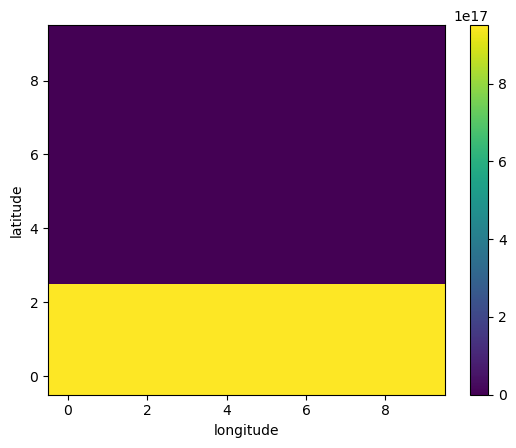

In [75]:
import numpy as np
import pandas as pd
import xarray as xr

warnings.simplefilter("once")



# Define the shape
shape = (10, 10, 100)

# Create the base 2D array with the specified pattern
base_array = np.zeros((10, 10), dtype=int)
base_array[0, :] = np.arange(1, 11)  # First row with integers 1-10
base_array[1, :] = 1  # Second row with all 1's
base_array[2, :] = 2  # Third row with all 2's

# Tile the base array along the time dimension to create a 3D array
degree_days_data = np.tile(base_array[:, :, np.newaxis], (1, 1, 100))

# Generate time coordinates
time = pd.date_range("2000-01-01", periods=100, freq="D")

# Create the xarray.DataArray
degree_days = xr.DataArray(
    degree_days_data,
    coords={
        "latitude": range(10),
        "longitude": range(10),
        "t": time,
    },
    dims=["latitude", "longitude", "t"],
)

latitude = degree_days["latitude"]
longitude = degree_days["longitude"]

# Optionally, chunk the array along the specified dimensions
degree_days = degree_days.chunk({"latitude": 5, "longitude": 5, "t": -1})
##################################################################





degree

start_indices = np.array(
    [np.where(degree_days.t.values == d)[0][0] for d in start_dates.values.flatten()]
).reshape(start_dates.shape)

threshold = 45


result_raw = xr.apply_ufunc(
    day_cumsum_reaches_threshold_linear,
    degree_days,
    start_indices,
    degree_days.t.values.astype("datetime64[ns]"),
    threshold,
    input_core_dims=[["t"], [], ["t"], []],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[],
)


def convert_to_datetime64_ns(value):
    if np.isnan(value):
        return np.datetime64("NaT", "ns")
    return np.datetime64(int(value), "ns")


result_raw.plot()
result = xr.apply_ufunc(
    np.vectorize(convert_to_datetime64_ns),
    result_raw,
    dask="parallelized",
    output_dtypes=[np.datetime64],
)

result.compute()

In [96]:
def create_start_index_array(start_dates, time_values):
    try:
        # Handle NaT values by assigning an invalid index (-1)
        start_indices = np.array(
            [
                -1 if np.isnat(d) else np.where(time_values == d)[0][0]
                for d in start_dates.values.flatten()
            ]
        ).reshape(start_dates.shape)

        return start_indices
    except IndexError:
        print(
            "Error: Start date not found in time dimension when creating start index array"
        )
        print(f"start_dates: {start_dates}")
        return None


def day_cumsum_reaches_threshold(
    degree_days, start_index, start_time_values, threshold
):
    # if degree_days contains NaN values, return NaT
    if np.isnan(degree_days).any():
        # print dimensions
        return 0
    cumsum = np.cumsum(degree_days[start_index:])
    if start_index == -1:
        return 0
    threshold_reached = np.where(cumsum >= threshold)[0]
    if len(threshold_reached) == 0:
        print(degree_days)
        warnings.warn("Development error: Threshold not reached")
        return 0
    # elisef start_index is None
    elif start_index is None:
        print(degree_days)
        warnings.warn("Development error: Start index is None")
        return 0

    else:
        first_reached_index = threshold_reached[0]
        result_date = start_time_values[start_index + first_reached_index]
        return result_date


def convert_to_datetime64_ns(value):
    if np.isnan(value):
        return np.datetime64("NaT", "ns")
    elif value == 0:
        return np.datetime64("NaT", "ns")
    return np.datetime64(int(value), "ns")


si = []


def compute_dd_threshold_reached_days(degree_days, start_dates, threshold):
    start_indices = create_start_index_array(start_dates, degree_days.t.values)
    si.append(start_indices)
    result_raw = xr.apply_ufunc(
        day_cumsum_reaches_threshold,
        degree_days,
        start_indices,
        degree_days.t.values.astype("datetime64[ns]"),
        threshold,
        input_core_dims=[["t"], [], ["t"], []],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["int64"],
    )

    result = xr.apply_ufunc(
        np.vectorize(convert_to_datetime64_ns),
        result_raw,
        dask="parallelized",
        output_dtypes=[np.datetime64],
    )

    return result

SyntaxError: expression expected after dictionary key and ':' (1477820063.py, line 1)

In [97]:
# compute the threshold reached days for the window
la_start_dates = create_start_date_array(la_window_dd, "2000-01-02")
la_threshold_reached_days_1 = compute_dd_threshold_reached_days(
    la_window_dd, la_start_dates, 10
)
la_threshold_reached_days_2 = compute_dd_threshold_reached_days(
    la_window_dd, la_threshold_reached_days_1, 10
)

/home/thom/miniforge3/envs/fruitflypheno_hdf5/lib/python3.12/site-packages/xarray/plot/utils.py:245: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


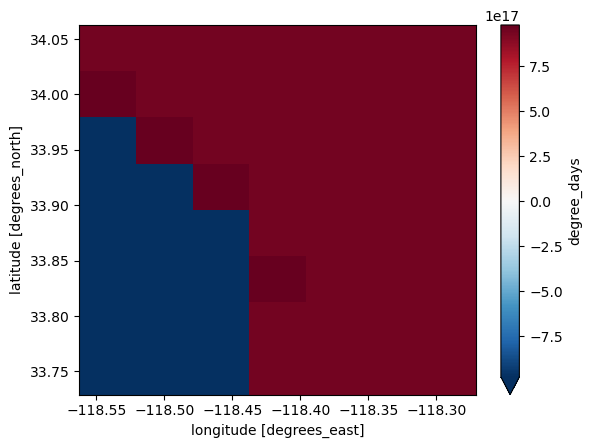

In [105]:
la_threshold_reached_days_2

# cast la_threshold_reached_days_2 to int and plot
la_threshold_reached_days_2.astype(int).plot()

In [106]:
la_threshold_reached_days_2

<xarray.DataArray 'degree_days' (latitude: 8, longitude: 7)> Size: 448B
array([['2000-01-09T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000'],
       ['2001-01-02T00:00:00.000000000', '2000-01-10T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000'],
       [                          'NaT', '2001-01-03T00:00:00.000000000',
        '2000-01-10T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
        '2001-01-03T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-07T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', '2000-01-10T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', '2001-01-03T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', '2000-01-09T00:00:00.000000000',
        '2000-01-08T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', '2000-01-09T00:00:00.000000000',
        '2000-01-08T00:00:00.000000000', '2000-01-07T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000']], dtype='datetime64[ns]')
Coordinates:
  * longitude  (longitude) float64 56B -118.5 -118.5 -118.5 ... -118.3 -118.3
  * latitude   (latitude) float64 64B 34.04 34.0 33.96 ... 33.83 33.79 33.75

In [93]:
si

[array([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]]),
 array([[     5,      5,      5,      5,      5,      5,      5],
        [     6,      5,      5,      5,      5,      5,      5],
        [-10000,      6,      5,      5,      5,      5,      5],
        [-10000, -10000,      6,      5,      5,      4,      5],
        [-10000, -10000, -10000,      5,      5,      5,      5],
        [-10000, -10000, -10000,      6,      5,      5,      5],
        [-10000, -10000, -10000,      5,      5,      5,      5],
        [-10000, -10000, -10000,      5,      5,      5,      5]])]

In [61]:
la_threshold_reached_days_1

<xarray.DataArray 'degree_days' (latitude: 8, longitude: 7)> Size: 448B
array([['2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000'],
       ['2000-01-07T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000'],
       [                          'NaT', '2000-01-07T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
        '2000-01-07T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', '2000-01-07T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000']], dtype='datetime64[ns]')
Coordinates:
  * longitude  (longitude) float64 56B -118.5 -118.5 -118.5 ... -118.3 -118.3
  * latitude   (latitude) float64 64B 34.04 34.0 33.96 ... 33.83 33.79 33.75

In [36]:
la_start_dates

<xarray.DataArray ()> Size: 8B
array('2000-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    latitude   float64 8B 34.04
    longitude  float64 8B -118.2

In [103]:
la_single_dd["latitude"]

<xarray.DataArray 'latitude' ()> Size: 8B
array(34.04166667)
Coordinates:
    longitude  float64 8B -118.2
    latitude   float64 8B 34.04
Attributes:
    _CoordinateAxisType:  latitude
    units:                degrees_north

In [86]:
create_start_date_array(la_window_dd, "2000-01-01")

<xarray.DataArray (latitude: 12, longitude: 12)> Size: 1kB
array([['2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000'],
       ['2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000'],
       ['2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000'],
       ['2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
...
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000'],
       ['2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000'],
       ['2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000'],
       ['2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
        '2000-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * latitude   (latitude) float64 96B 34.12 34.08 34.04 ... 33.75 33.71 33.67
  * longitude  (longitude) float64 96B -118.6 -118.6 -118.5 ... -118.2 -118.2

In [88]:
# apply the function to the PRISM data

# create xarray of model dates matching input shape matching start date e.g. in the xy shape of la_window_dd with coordinartes
# of la_window_dd


model_start_date = np.datetime64("2001-01-01", "ns")

date_array_np = np.array(
    [
        model_start_date
        for i in range(la_window_dd.sizes["latitude"] * la_window_dd.sizes["longitude"])
    ]
).reshape(la_window_dd.sizes["latitude"], la_window_dd.sizes["longitude"])

# create xarray with the same shape as la_window_dd lat/long  with only one time dimension
date_array_xr = xr.DataArray(
    date_array_np,
    dims=["latitude", "longitude"],
    coords={
        "latitude": la_window_dd["latitude"],
        "longitude": la_window_dd["longitude"],
    },
)

#create start indices array 

In [4]:
# create start date array for la_window_dd
la_start_dates = create_start_date_array(la_window_dd, "2000-01-01")
la_start_indices = create_start_index_array(la_start_dates, la_window_dd.t.values)

NameError: name 'la_window_dd' is not defined

In [67]:
# Create a 10x10x10 array of dates starting from January 1st, 2000
time = pd.date_range("2000-01-01", periods=10, freq="D")
# set time to datetime64[ns]
time = time.to_numpy(dtype="datetime64[ns]")

time = np.tile(time.to_numpy(dtype="datetime64[ns]"), (10, 10, 1))

# Make it into an xarray
time_array = xr.DataArray(
    time,
    dims=["x", "y", "time"],
    coords={
        "x": range(10),
        "y": range(10),
        "time": pd.date_range("2000-01-01", periods=10, freq="D"),
    },
)
index = 3
# split into 5x5x5 chunkas
time_array = time_array.chunk({"x": 5, "y": 5})


def demo_time_function(time_array, index):

    return time_array[index]


# Apply the function using xr.apply_ufunc
result = xr.apply_ufunc(
    demo_time_function,
    time_array,
    index,
    input_core_dims=[["time"], []],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[],
)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [73]:
import dask.array as da
import numpy as np
import pandas as pd


def day_cumsum_reaches_threshold_linear_dask(
    degree_days, start_index, time_values, threshold
):
    """
    Computes the date when the cumulative sum of degree_days reaches the given threshold,
    starting from the specified start_index, using Dask for parallel processing.

    Parameters:
    - degree_days (da.Array): Dask array of degree days.
    - start_index (da.Array): Dask array of starting indices.
    - time_values (da.Array): Dask array of time values.
    - threshold (float): The threshold value for cumulative sum.

    Returns:
    - da.Array: Dask array of dates when the cumulative sum reaches the threshold.
    """

    # Compute cumulative sum starting from the start_index
    def compute_cumsum(degree_days, start_index):
        cumsum = np.cumsum(degree_days[start_index:])
        return cumsum

    # Define a function to find the date when the threshold is reached
    def find_threshold_date(degree_days, start_index, time_values, threshold):
        cumsum = compute_cumsum(degree_days, start_index)
        threshold_reached = np.where(cumsum >= threshold)[0]

        if len(threshold_reached) == 0:
            return np.datetime64(
                "NaT"
            )  # Return Not-a-Time if the threshold is not reached

        first_reach_index = threshold_reached[0]
        result_date = time_values[start_index + first_reach_index]
        return np.datetime64(result_date, "D")

    # Use Dask's map_blocks to apply the function across all chunks
    result = da.map_blocks(
        lambda degree_days_chunk, start_index_chunk, time_values_chunk: np.array(
            [
                find_threshold_date(
                    degree_days_chunk, start_idx, time_values_chunk, threshold
                )
                for start_idx in start_index_chunk
            ]
        ),
        degree_days,
        start_index,
        time_values,
        dtype="datetime64[D]",
    )

    return result


# Example usage with Dask
import dask.array as da

# Example data
time_values = da.from_array(pd.date_range("2000-01-01", periods=50, freq="D"))
degree_days = da.from_array(np.random.random(50), chunks=10)
start_index = da.from_array(np.arange(50), chunks=10)
threshold = 2  # Example threshold

result = day_cumsum_reaches_threshold_linear_dask(
    degree_days, start_index, time_values, threshold
)
print(result.compute())

['2000-01-05' '2000-01-05' '2000-01-06' '2000-01-06' '2000-01-07'
 '2000-01-08' '2000-01-10'        'NaT'        'NaT'        'NaT'
        'NaT'        'NaT'        'NaT'        'NaT'        'NaT'
        'NaT'        'NaT'        'NaT'        'NaT'        'NaT'
        'NaT'        'NaT'        'NaT'        'NaT'        'NaT'
        'NaT'        'NaT'        'NaT'        'NaT'        'NaT'
        'NaT'        'NaT'        'NaT'        'NaT'        'NaT'
        'NaT'        'NaT'        'NaT'        'NaT'        'NaT'
        'NaT'        'NaT'        'NaT'        'NaT'        'NaT'
        'NaT'        'NaT'        'NaT'        'NaT'        'NaT']


In [39]:
import xarray as xr
import numpy as np
import pandas as pd


def day_cumsum_reaches_threshold(degree_days, time_coords, start_day, threshold):
    # Perform cumulative sum and threshold check
    cumsum = np.cumsum(degree_days[start_day:], axis=-1)
    threshold_reached = np.where(cumsum >= threshold)[0]

    # Check if the threshold was reached
    if len(threshold_reached) == 0:
        return np.datetime64("NaT")  # Return Not-a-Time if the threshold is not reached

    # Compute the date when the threshold was first reached
    date_index = threshold_reached[0]
    date = np.datetime64(time_coords[start_day + date_index], "D")
    print(date)
    return date


# Example of applying the function over a larger dataset with Dask
def apply_cumsum_threshold(dataset, start_day, threshold):
    result = xr.apply_ufunc(
        day_cumsum_reaches_threshold,
        dataset,
        input_core_dims=[["t"]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        kwargs={"start_day": start_day, "threshold": threshold},
        output_dtypes=[np.datetime64],
    )
    return result


# Create a sample dataset with Dask
lat = np.arange(10)
lon = np.arange(10)
time = pd.date_range("2000-01-01", periods=10)
data = np.random.rand(10, 10, 10)
degree_days = xr.DataArray(data, coords=[lat, lon, time], dims=["lat", "lon", "t"])
# Convert to a Dask array
degree_days = degree_days.chunk({"lat": 5, "lon": 5})

start_day = 0  # example start day
threshold = 5  # example threshold

# Apply the function over the larger dataset
result = apply_cumsum_threshold(degree_days, start_day, threshold)

# Compute the result
computed_result = result.compute()
print(computed_result)

2024-08-14 13:26:44,701 - distributed.worker - WARNING - Compute Failed
Key:       ('vectorize_day_cumsum_reaches_threshold-vectorize_day_cumsum_reaches_threshold_0-transpose-1b099fadfcb9a00af744e8f24--60a', 1, 0)
State:     executing
Function:  execute_task
args:      ((subgraph_callable-8545799b656b41ceee0012e91c241be1, (subgraph_callable-1443e4bc1f93a67dc47c024f981b3cbe, (<function concatenate_axes at 0x7dffb493c0e0>, [array([[[0.23695819, 0.019066  , 0.01263238, 0.05629709, 0.5644703 ,
         0.82097152, 0.267617  , 0.17813238, 0.09494849, 0.36181699],
        [0.95704247, 0.49117351, 0.21995795, 0.83107688, 0.20602493,
         0.43727969, 0.1819227 , 0.89562084, 0.71185332, 0.56684085],
        [0.86954467, 0.96298727, 0.10294405, 0.74761762, 0.89093795,
         0.11153684, 0.55813579, 0.35962515, 0.49234164, 0.0621894 ],
        [0.2724583 , 0.64912999, 0.49322174, 0.52635799, 0.02363424,
         0.04032899, 0.75389124, 0.35406253, 0.01350004, 0.16435251],
        [0.6016293

TypeError: day_cumsum_reaches_threshold() missing 1 required positional argument: 'time_coords'

In [ ]:
#create a list of start dates for each year from 2000 to 2008
start_dates = []
model_month = 1
model_day = 1
for year in range(2000, 2009):
    start_dates.append(datetime.datetime(year, model_month, model_day))

In [81]:
threshold = 15

# Compute the day when cumulative sum reaches the threshold starting from day 1
start_day = "2001-01-06"
day_reach_threshold_from_start = day_cumsum_reaches_threshold(
    la_window_dd, start_day, threshold
)

In [ ]:
# la_combined_DD["degree_days"].isel(t=slice(4, None))
# repeat but use .sel for date 01-03-2001
la_combined_DD["degree_days"].sel(t=slice("2001-01-03", None))

In [ ]:
tmax[42]

In [ ]:
tmin[42]

In [ ]:
import xarray as xr
import numpy as np


def calculate_degree_days(tmax, tmin, base_temp=10):
    """
    Calculate degree days from tmax and tmin.
    Degree days = (tmax + tmin) / 2 - base_temp
    """
    mean_temp = (tmax + tmin) / 2
    degree_days = mean_temp - base_temp
    return degree_days


def process_dataset(dataset):
    """
    Apply degree days calculation and drop tmax and tmin variables.
    """
    # Directly access tmax and tmin
    tmax = dataset["tmax"]
    tmin = dataset["tmin"]

    # Print dimensions and coordinates for debugging
    print("Dimensions of tmax:", tmax.dims)
    print("Dimensions of tmin:", tmin.dims)
    print("Coordinates of dataset:", dataset.coords)

    # Calculate degree days using apply_ufunc
    degree_days = xr.apply_ufunc(
        single_sine_horizontal_cutoff,
        tmax,
        tmin,
        input_core_dims=[["t"], ["t"]],
        output_core_dims=[["t"]],  # No core dimensions for the output
        vectorize=True,
        dask="allowed",  # Ensure compatibility with dask
        output_dtypes=[float],  # Specify output data type
    )

    # Print dimensions of degree_days for debugging
    print("Dimensions of degree_days:", degree_days.dims)

    # Create a new DataArray with the degree days
    degree_days_da = xr.DataArray(
        degree_days,
        dims=["time"],  # Use 'time' dimension for the DataArray
        coords={
            "time": dataset["time"].values
        },  # Use 'time' coordinate from the original dataset
        name="degree_days",
    )

    # Add degree days to the dataset and drop tmax and tmin
    dataset = dataset.assign(degree_days=degree_days_da)
    dataset = dataset.drop_vars(["tmax", "tmin"])

    return dataset


# Example usage
base_dir = data_path
start_year = 2000
end_year = 2020
start_day = 1
end_day = 10

combined_dataset = load_and_concatenate_datasets(
    start_year, end_year, start_day, end_day, base_dir
)

# Process the dataset
processed_dataset = process_dataset(combined_dataset)

# Persist or compute if needed
processed_dataset = processed_dataset.persist()

# Subset dataset by coordinates
la_combined = subset_dataset_by_coords(processed_dataset, 34.05, -118.25)

# Print dataset information
print(la_combined)
print(la_combined.dims)
print(la_combined.variables)

In [ ]:
import xarray as xr
import numpy as np
from dask import array as da


def process_dataset(dataset):
    """
    Apply degree days calculation and drop tmax and tmin variables.
    """
    # Ensure tmax and tmin are dask arrays
    tmax = dataset["tmax"]
    tmin = dataset["tmin"]

    # Calculate degree days using map_blocks
    degree_days = da.map_blocks(
        lambda tmax, tmin: single_sine_horizontal_cutoff(tmax, tmin),
        tmax,
        tmin,
        dtype=float,
    )

    # Create a new DataArray with the degree days
    degree_days_da = xr.DataArray(degree_days, dims=dataset.dims, coords=dataset.coords)

    # Add degree days to the dataset and drop tmax and tmin
    dataset = dataset.assign(degree_days=degree_days_da)
    dataset = dataset.drop_vars(["tmax", "tmin"])

    return dataset


# Process the dataset
processed_la = process_dataset(la_combined)

processed_la = processed_la.compute()
# Subset dataset by coordinates

# Print dataset information

In [ ]:
import xarray as xr
import numpy as np
from dask import array as da


def calculate_degree_days(tmax, tmin, base_temp=10):
    """
    Calculate degree days from tmax and tmin.
    Degree days = (tmax + tmin) / 2 - base_temp
    """
    mean_temp = (tmax + tmin) / 2
    degree_days = mean_temp - base_temp
    return degree_days


def process_dataset(dataset):
    """
    Apply degree days calculation and drop tmax and tmin variables.
    """
    # Directly access tmax and tmin
    tmax = dataset["tmax"]
    tmin = dataset["tmin"]

    # Calculate degree days
    degree_days = xr.apply_ufunc(
        calculate_degree_days,
        tmax,
        tmin,
        input_core_dims=[["time"], ["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="allowed",  # Ensure compatibility with dask
    )

    # Create a new DataArray with the degree days
    degree_days_da = xr.DataArray(
        degree_days,
        dims=dataset.dims,  # Use dimensions from the original dataset
        coords=dataset.coords,  # Use coordinates from the original dataset
        name="degree_days",
    )

    # Add degree days to the dataset and drop tmax and tmin
    dataset = dataset.assign(degree_days=degree_days_da)
    dataset = dataset.drop_vars(["tmax", "tmin"])

    return dataset


processed_dataset = process_dataset(la_combined)

# Persist or compute if needed
processed_dataset = processed_dataset.persist()

In [ ]:
print(la_combined)

In [ ]:
import dask.array as da
import numpy as np

# Define the shape of the array
lat, lon = 10, 10
days_per_year = 365
years = 2
variables = 2  # tmean and tmax
total_days = days_per_year * years

# Create larger random data for tmean and tmax to ensure cumulative sum can reach 50
tmean_data = np.random.rand(total_days, lat, lon) * 10
tmax_data = np.random.rand(total_days, lat, lon) * 10

# Stack the data along a new axis to create a single array
data = np.stack([tmean_data, tmax_data], axis=0)  # Shape will be (variables, total_days, lat, lon)

# Convert the numpy array to a dask array
dask_array = da.from_array(data, chunks=(variables, days_per_year//4, lat//2, lon//2))  # Adjust chunks as needed

# Add one to every day for each variable
dask_array_plus_one = dask_array + 1

# Split the array into separate years
dask_array_years = [dask_array_plus_one[:, i*days_per_year:(i+1)*days_per_year, :, :] for i in range(years)]

# Calculate the cumulative sum along the time (days) axis for each year
cumsum_arrays = [da.cumsum(year, axis=1) for year in dask_array_years]

# Function to find the first day when the cumulative sum is >= 50
def find_day_where_cumsum_is_50(cumsum_slice):
    condition_met = (cumsum_slice >= 50)
    if condition_met.any():
        return condition_met.argmax(axis=0)
    else:
        # Return days_per_year if the condition is never met
        return days_per_year * np.ones_like(cumsum_slice[0], dtype=int)

# Apply the function along the days axis (axis=1) for each year's cumulative sum
days_reaching_50_each_year = [da.apply_along_axis(find_day_where_cumsum_is_50, 1, cumsum) for cumsum in cumsum_arrays]

# Stack the results to get an array of shape (years, variables, lat, lon)
days_reaching_50_result = da.stack(days_reaching_50_each_year)

# Compute the result
days_reaching_50_result_computed = days_reaching_50_result.compute()

# Verification: Check some values from the result
print("Shape of days_reaching_50_result_computed:", days_reaching_50_result_computed.shape)
print("Days reaching 50 for tmean (variable 0) in year 1:")
print(days_reaching_50_result_computed[0, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 1:")
print(days_reaching_50_result_computed[0, 1])
print("\nDays reaching 50 for tmean (variable 0) in year 2:")
print(days_reaching_50_result_computed[1, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 2:")
print(days_reaching_50_result_computed[1, 1])


In [ ]:
ds = nc.Dataset("data/test/derived/PRISM_mean_2000-2020.nc", "r", format="NETCDF4")

In [ ]:
# take mean of netcdf "data/test/PRISM/2020/PRISM_combo_20200101.nc"

# Open the NetCDF file
dataset = nc.Dataset("data/test/PRISM/2020/PRISM_combo_20200101.nc", "r")

In [ ]:
dataset = nc.Dataset("data/test/PRISM/2020/PRISM_combo_20200101.nc", "r")

In [ ]:
import concurrent.futures
import time


def compute(x):
    time.sleep(2)  # Simulate a time-consuming computation
    return x * x


def main():
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit tasks to the executor
        futures = [executor.submit(compute, i) for i in range(5)]

        for future in concurrent.futures.as_completed(futures):
            result = future.result()  # This blocks until the result is available
            print(f"Result: {result}")


if __name__ == "__main__":
    main()

In [ ]:
import netCDF4 as nc
import numpy as np


def extract_values_from_ncdf(file_path, coord, variables):
    """
    Extract values at a given coordinate from specified variables in a NetCDF file.

    Parameters:
    - file_path (str): Path to the NetCDF file.
    - coord (tuple): Tuple of (latitude, longitude) for the target coordinate.
    - variables (list): List of variable names to extract.

    Returns:
    - dict: A dictionary with variable names as keys and extracted values as values.
    """
    target_lat, target_lon = coord

    with nc.Dataset(file_path, "r") as dataset:
        # Get the latitude and longitude variables
        lat = dataset.variables["latitude"][:]
        lon = dataset.variables["longitude"][:]

        # Find the nearest indices for the given coordinates
        lat_idx = np.abs(lat - target_lat).argmin()
        lon_idx = np.abs(lon - target_lon).argmin()

        # Extract values for each variable
        values = tuple(
            dataset.variables[var][0, lat_idx, lon_idx].data.item() for var in variables
        )
        # note to potentially clip NCDF values
    return values


# Example usage:
file_path = "data/test/PRISM/2020/PRISM_combo_20200101.nc"
coord = (34.05, -118.25)
variables = ["tmin", "tmax"]
values = extract_values_from_ncdf(file_path, coord, variables)
print(values)

In [ ]:
import concurrent.futures
import netCDF4 as nc
import numpy as np


def extract_values(file_path, coord, variables):
    target_lat, target_lon = coord

    with nc.Dataset(file_path, "r") as dataset:
        lat = dataset.variables["latitude"][:]
        lon = dataset.variables["longitude"][:]

        lat_idx = np.abs(lat - target_lat).argmin()
        lon_idx = np.abs(lon - target_lon).argmin()

        values = tuple(
            dataset.variables[var][0, lat_idx, lon_idx].data.item() for var in variables
        )

    return values


def process_day(file_path, coord, variables, LTT, UTT):
    tmin, tmax = extract_values(file_path, coord, variables)
    return single_sine_horizontal_cutoff(tmin, tmax, LTT, UTT)


def process_days_concurrently(file_path, coord, variables, LTT, UTT, dates):
    results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for date in dates:
            # Submit the process_day task to the executor
            future = executor.submit(process_day, file_path, coord, variables, LTT, UTT)
            futures.append(future)

        # Collect results as they complete
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())

    return results


# Example usage
file_path = "your_file.nc"
coord = (34.05, -118.25)
variables = ["tmin", "tmax"]
LTT = 10
UTT = 20
dates = ["2024-07-01", "2024-07-02", "2024-07-03"]

results = process_days_concurrently(file_path, coord, variables, LTT, UTT, dates)
print(results)

In [ ]:
import netCDF4 as nc
import numpy as np


def get_file_path_PRISM(year, month, day, base_dir):
    
    
    file_path = f"{base_dir}/{year}/PRISM_combo_{year}{month}{day}.nc"
    return file_path


def extract_values(file_path, coord, variables):
    target_lat, target_lon = coord

    with nc.Dataset(file_path, "r") as dataset:
        lat = dataset.variables["latitude"][:]
        lon = dataset.variables["longitude"][:]

        lat_idx = np.abs(lat - target_lat).argmin()
        lon_idx = np.abs(lon - target_lon).argmin()

        values = tuple(
            dataset.variables[var][0, lat_idx, lon_idx].data.item() for var in variables
        )

    return values


def process_days(start_date, coord, variables, LTT, UTT, target_GDD_value):
    accumulated_GDD_result = 0
    
    data_date = start_date
    while accumulated_GDD_result < target_GDD_value:
        date_path = get_file_path_PRISM(data_date.year, data_date.month, data_date.day, "data/test/PRISM/")

        tmin, tmax = extract_values(file_path, coord, variables)
        daily_result = single_sine_horizontal_cutoff(tmin, tmax, LTT, UTT)
        accumulated_GDD_result += daily_result
        

        
    return accumulated_result, total_days_processed

In [ ]:
get_file_paths(2020, "01", "01", "data/test/PRISM")

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the NetCDF file

# Get the latitude and longitude variables
lat = dataset.variables["latitude"][:]
lon = dataset.variables["longitude"][:]

# Get the data variable (e.g., temperature)
data = dataset.variables["tmax"][:]

# Your target coordinate
target_lat = 34.05  # example latitude
target_lon = -118.25  # example longitude

# Find the nearest indices for the given coordinates
lat_idx = np.abs(lat - target_lat).argmin()
lon_idx = np.abs(lon - target_lon).argmin()

# Plot the data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Plot the data as a contourf plot
plt.contourf(lon, lat, data[0, :, :], transform=ccrs.PlateCarree(), cmap="coolwarm")
plt.colorbar(label="Temperature")

# Plot the target point
plt.plot(target_lon, target_lat, "bo", markersize=10, transform=ccrs.PlateCarree())
plt.text(target_lon + 0.5, target_lat, "Target Point", transform=ccrs.PlateCarree())

# Add title and labels
plt.title("Temperature Map with Target Point")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close the dataset
dataset.close()

In [ ]:
import dask.array as da
import numpy as np

# Define the shape of the array
lat, lon = 10, 10
days_per_year = 365
years = 2
variables = 2  # tmean and tmax
total_days = days_per_year * years

# Create larger random data for tmean and tmax to ensure cumulative sum can reach 50
tmean_data = np.random.rand(total_days, lat, lon) * 10
tmax_data = np.random.rand(total_days, lat, lon) * 10

# Stack the data along a new axis to create a single array
data = np.stack(
    [tmean_data, tmax_data], axis=0
)  # Shape will be (variables, total_days, lat, lon)

# Convert the numpy array to a dask array
dask_array = da.from_array(
    data, chunks=(variables, days_per_year // 4, lat // 2, lon // 2)
)  # Adjust chunks as needed

# Add one to every day for each variable
dask_array_plus_one = dask_array + 1

# Split the array into separate years
dask_array_years = [
    dask_array_plus_one[:, i * days_per_year : (i + 1) * days_per_year, :, :]
    for i in range(years)
]

# Calculate the cumulative sum along the time (days) axis for each year
cumsum_arrays = [da.cumsum(year, axis=1) for year in dask_array_years]


# Function to find the first day when the cumulative sum is >= 50
def find_day_where_cumsum_is_50(cumsum_slice):
    condition_met = cumsum_slice >= 50
    if condition_met.any():
        return condition_met.argmax(axis=0)
    else:
        # Return days_per_year if the condition is never met
        return days_per_year * np.ones_like(cumsum_slice[0], dtype=int)


# Apply the function along the days axis (axis=1) for each year's cumulative sum
days_reaching_50_each_year = [
    da.apply_along_axis(find_day_where_cumsum_is_50, 1, cumsum)
    for cumsum in cumsum_arrays
]

# Stack the results to get an array of shape (years, variables, lat, lon)
days_reaching_50_result = da.stack(days_reaching_50_each_year)

# Compute the result
days_reaching_50_result_computed = days_reaching_50_result.compute()

# Verification: Check some values from the result
print(
    "Shape of days_reaching_50_result_computed:", days_reaching_50_result_computed.shape
)
print("Days reaching 50 for tmean (variable 0) in year 1:")
print(days_reaching_50_result_computed[0, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 1:")
print(days_reaching_50_result_computed[0, 1])
print("\nDays reaching 50 for tmean (variable 0) in year 2:")
print(days_reaching_50_result_computed[1, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 2:")
print(days_reaching_50_result_computed[1, 1])

In [ ]:
import dask.array as da
import numpy as np

# Define the shape of the array
lat, lon = 10, 10
days_per_year = 365
years = 2
variables = 2  # tmean and tmax
total_days = days_per_year * years

# Create larger random data for tmean and tmax to ensure cumulative sum can reach 50
tmean_data = np.random.rand(total_days, lat, lon) * 10
tmax_data = np.random.rand(total_days, lat, lon) * 10

# Stack the data along a new axis to create a single array
data = np.stack(
    [tmean_data, tmax_data], axis=0
)  # Shape will be (variables, total_days, lat, lon)

# Convert the numpy array to a dask array
dask_array = da.from_array(
    data, chunks=(variables, days_per_year // 4, lat // 2, lon // 2)
)  # Adjust chunks as needed

# Add one to every day for each variable
dask_array_plus_one = dask_array + 1

# Split the array into separate years
dask_array_years = [
    dask_array_plus_one[:, i * days_per_year : (i + 1) * days_per_year, :, :]
    for i in range(years)
]

# Calculate the cumulative sum along the time (days) axis for each year
cumsum_arrays = [da.cumsum(year, axis=1) for year in dask_array_years]


# Function to find the first day when the cumulative sum is >= 50
def find_day_where_cumsum_is_50(cumsum_slice):
    condition_met = cumsum_slice >= 50
    if condition_met.any():
        return condition_met.argmax(axis=0)
    else:
        # Return days_per_year if the condition is never met
        return days_per_year * np.ones_like(cumsum_slice[0], dtype=int)


# Apply the function along the days axis (axis=1) for each year's cumulative sum
days_reaching_50_each_year = [
    da.apply_along_axis(find_day_where_cumsum_is_50, 1, cumsum)
    for cumsum in cumsum_arrays
]

# Stack the results to get an array of shape (years, variables, lat, lon)
days_reaching_50_result = da.stack(days_reaching_50_each_year)

# Compute the result
days_reaching_50_result_computed = days_reaching_50_result.compute()

# Verification: Check some values from the result
print(
    "Shape of days_reaching_50_result_computed:", days_reaching_50_result_computed.shape
)
print("Days reaching 50 for tmean (variable 0) in year 1:")
print(days_reaching_50_result_computed[0, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 1:")
print(days_reaching_50_result_computed[0, 1])
print("\nDays reaching 50 for tmean (variable 0) in year 2:")
print(days_reaching_50_result_computed[1, 0])
print("\nDays reaching 50 for tmax (variable 1) in year 2:")
print(days_reaching_50_result_computed[1, 1])

In [ ]:
days_reaching_50_result.visualize()

In [ ]:
samp